Copyright 2021-2023 Lawrence Livermore National Security, LLC and other MuyGPyS
Project Developers. See the top-level COPYRIGHT file for details.

SPDX-License-Identifier: MIT

# Anisotropic tutorial with optimization loop chassis

This notebook walks through four experimental treatments using the optimaztion loop chassis and 2D Univariate Sampler used in the [Anisotropic Metric Tutorial](../docs/examples/anisotropic_tutorial.ipynb). The goal is increase accuracy of learned hyperparameters in order to best recover the response on the held-out test data by training a simple anisotropic `MuyGPS` model on the perturbed training data with `nu` smoothness hyperparameter known, while the two `distance scaling` hyperparameters are to be learned. Each iteration of the optimization loop we scale training features using learned length scale hyperparameters, update nearest neighbors lookup using sklearn, update objective function, and run bayes optimization using numpy math backend.

In [6]:
# import sys
# for m in sys.modules.keys():
#     if m.startswith("Muy"):
#         sys.modules.pop(m)
# %env MUYGPYS_BACKEND=numpy
# %env MUYGPYS_FTYPE=64


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from MuyGPyS._test.sampler import UnivariateSampler2D

from MuyGPyS.gp import MuyGPS
from MuyGPyS.gp.distortion import AnisotropicDistortion, l2
from MuyGPyS.gp.hyperparameter import ScalarHyperparameter
from MuyGPyS.gp.kernels import Matern
from MuyGPyS.gp.noise import HomoscedasticNoise
from MuyGPyS.gp.tensors import make_predict_tensors
from MuyGPyS.optimize.experimental.chassis import optimize_from_tensors_mini_batch
from MuyGPyS.optimize.loss import mse_fn, lool_fn


np.random.seed(0)

points_per_dim = 60                             # Observations per dimension
train_step = 13                                 # Train/test data split
nugget_noise = HomoscedasticNoise(1e-14)        # Assume no noise in truth
measurement_noise = HomoscedasticNoise(1e-7)    # Noise to perturb train
sim_nu = ScalarHyperparameter(1.5)              # HP smoothness
sim_length_scale0 = ScalarHyperparameter(0.1)   # HP distance scaling dim 0
sim_length_scale1 = ScalarHyperparameter(0.5)   # HP distance scaling dim 1
sampler = UnivariateSampler2D(
    points_per_dim=points_per_dim,
    train_step=train_step,
    kernel=Matern(
        nu=sim_nu,
        metric=AnisotropicDistortion(
            l2,
            length_scale0=sim_length_scale0,
            length_scale1=sim_length_scale1,
        ),
    ),
    eps=nugget_noise,
    measurement_eps=measurement_noise,
)
train_features, test_features = sampler.features()
train_responses, test_responses = sampler.sample()
# TODO sampler.plot_sample()

exp_length_scale0 = ScalarHyperparameter("log_sample", (0.01, 1.0))
exp_length_scale1 = ScalarHyperparameter("log_sample", (0.01, 1.0))
muygps = MuyGPS(
    kernel=Matern(
        nu=sim_nu,
        metric=AnisotropicDistortion(
            l2,
            length_scale0=exp_length_scale0,
            length_scale1=exp_length_scale1,
        ),
    ),
    eps=measurement_noise,
)


In [8]:
opt_kwargs = {
    "loss_fn": lool_fn,
    "obj_method": "loo_crossval",
    "verbose": False,
    "random_state": 1,
    "init_points": 5,
    "n_iter": 20,
    "allow_duplicate_points": True,
}

opt_kwargs1a = {
    "loss_fn": lool_fn,
    "obj_method": "loo_crossval",
    "verbose": False,
    "random_state": 1,
    "init_points": 25,
    "n_iter": 100,
    "allow_duplicate_points": True,
}

train_table = [
    [
        "treatment",
        "time (s)",
        "train size",
        "batch size", 
        "num epochs",
        "pts probed",
        "l.s.0 (p.e.) ",
        "l.s.1 (p.e.) ",
        "sigma sq",
    ]
]

inference_table = [
    [
        "treatment",
        "RMSE",
        "mean diag var",
        "mean c.i. size ",
        "coverage",
    ]
]

inference_data = []

def store_details(
        name,
        batch_size,
        train_size,
        epoch_count,
        muygps_exp,
        nbrs_lookup_final,
        exec_time,
        probe_count
    ):

    # Training results
    learned_sim_length_scale0 = muygps_exp.kernel.distortion_fn.length_scale['length_scale0']()
    pe0 = abs(learned_sim_length_scale0 - sim_length_scale0()) / sim_length_scale0() * 100.0
    learned_sim_length_scale1 = muygps_exp.kernel.distortion_fn.length_scale['length_scale1']()
    pe1 = abs(learned_sim_length_scale1 - sim_length_scale1()) / sim_length_scale1() * 100.0
    ret = [
        name,
        f"{exec_time:.6f}",
        f"{train_size}",
        f"{batch_size}",
        f"{epoch_count}",
        f"{probe_count}",
        f"{learned_sim_length_scale0:.4f} ({pe0:2.0f}%)",
        f"{learned_sim_length_scale1:.4f} ({pe1:2.0f}%)",
        f"{muygps_exp.sigma_sq()[0]:.4f}",
    ]
    train_table.append(ret)

    # Inference results
    test_count, _ = test_features.shape
    indices = np.arange(test_count)
    test_nn_indices, _ = nbrs_lookup_final.get_nns(test_features)
    (
        test_crosswise_diffs,
        test_pairwise_diffs,
        test_nn_targets,
    ) = make_predict_tensors(
        indices,
        test_nn_indices,
        test_features,
        train_features,
        train_responses,
    )
    Kcross = muygps_exp.kernel(test_crosswise_diffs)
    K = muygps_exp.kernel(test_pairwise_diffs)
    predictions = muygps_exp.posterior_mean(K, Kcross, test_nn_targets)
    variances = muygps_exp.posterior_variance(K, Kcross)
    confidence_intervals = np.sqrt(variances) * 1.96
    coverage = (
        np.count_nonzero(
            np.abs(test_responses - predictions) < confidence_intervals
        ) / test_count
    )
    ret = [
        name,
        f"{np.sqrt(mse_fn(predictions, test_responses)):.5f}",
        f"{np.mean(variances):.5f}",
        f"{np.mean(confidence_intervals * 2):.5f}",
        f"{coverage:.5f}",
    ]    
    inference_table.append(ret)
    inference_data.append([predictions, confidence_intervals])



Treatment #1a (baseline) - brute force workflow following [Anisotropic Metric Tutorial](../docs/examples/anisotropic_tutorial.ipynb) using single optimization step with a single initial probe point

In [9]:
(
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
) = optimize_from_tensors_mini_batch(
    muygps,
    train_features,
    train_responses,
    nn_count=30,
    batch_count=sampler.train_count,
    train_count=sampler.train_count,
    num_epochs=1,
    keep_state=False,
    probe_previous=False,
    **opt_kwargs,
)
store_details(
    "single step",
    sampler.train_count,
    sampler.train_count,
    1,
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
)


Treatment #1b - baseline +  configured to exploit and explore same total points 

In [10]:
(
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
) = optimize_from_tensors_mini_batch(
    muygps,
    train_features,
    train_responses,
    nn_count=30,
    batch_count=sampler.train_count,
    train_count=sampler.train_count,
    num_epochs=1,
    keep_state=False,
    probe_previous=False,
    **opt_kwargs1a,
)
store_details(
    "single step+",
    sampler.train_count,
    sampler.train_count,
    1,
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
)
  

Treatment #2a (opt loop) - each loop interation create new optimizer instance, initialize with new objective function, and do not probe previous points

In [11]:
(
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
) = optimize_from_tensors_mini_batch(
    muygps,
    train_features,
    train_responses,
    nn_count=30,
    batch_count=55,
    train_count=sampler.train_count,
    num_epochs=(int(sampler.train_count / 55)),
    keep_state=False,
    probe_previous=False,
    **opt_kwargs,
)
store_details(
    "no probe",
    55,
    sampler.train_count,
    (int(sampler.train_count / 55)),
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
)


Treatment #2b (opt loop) - each loop interation create new optimizer instance, initialize with new objective function, and probe previous points

In [12]:
(
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
) = optimize_from_tensors_mini_batch(
    muygps,
    train_features,
    train_responses,
    nn_count=30,
    batch_count=55,
    train_count=sampler.train_count,
    num_epochs=(int(sampler.train_count / 55)),
    keep_state=False,
    probe_previous=True,
    **opt_kwargs,
)
store_details(
    "probe all",
    55,
    sampler.train_count,
    (int(sampler.train_count / 55)),
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
)


Data point [0.17567368 0.98265354] is not unique. 1 duplicates registered. Continuing ...
Data point [0.17567368 0.98265354] is not unique. 1 duplicates registered. Continuing ...


Treatment #2c (opt loop) - each loop interation reuse optimizer instance, set `BayesianOptimization.TargetSpace.target_function` to new objective function, and do not probe previous points 

In [13]:
(
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
) = optimize_from_tensors_mini_batch(
    muygps,
    train_features,
    train_responses,
    nn_count=30,
    batch_count=sampler.train_count,
    train_count=sampler.train_count,
    num_epochs=5,
    keep_state=True,
    probe_previous=False,
    **opt_kwargs,
)
store_details(
    "reuse opt",
    sampler.train_count,
    sampler.train_count,
    5,
    muygps_optloop,
    nbrs_lookup_final,
    exec_time,
    probe_count,
)


Training and inference results

treatment    |time (s)     |train size   |batch size   |num epochs   |pts probed   |l.s.0 (p.e.) |l.s.1 (p.e.) |sigma sq     
-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------
single step  |11.620304    |277          |277          |1            |6            |0.1870 (87%) |0.9781 (96%) |0.8695       
single step +|44.542234    |277          |277          |1            |26           |0.1082 ( 8%) |0.5893 (18%) |0.8695       
no probe     |33.591359    |277          |55           |5            |26           |0.1259 (26%) |1.0000 (100%)|0.8418       
probe all    |30.002794    |277          |55           |5            |40           |0.0915 ( 9%) |0.5273 ( 5%) |0.7732       
reuse opt    |64.493787    |277          |277          |5            |26           |0.1167 (17%) |0.6670 (33%) |0.8244       


treatment      |RMSE           |mean diag var  |mean c.i. size |coverage       
---------------|---------------|----

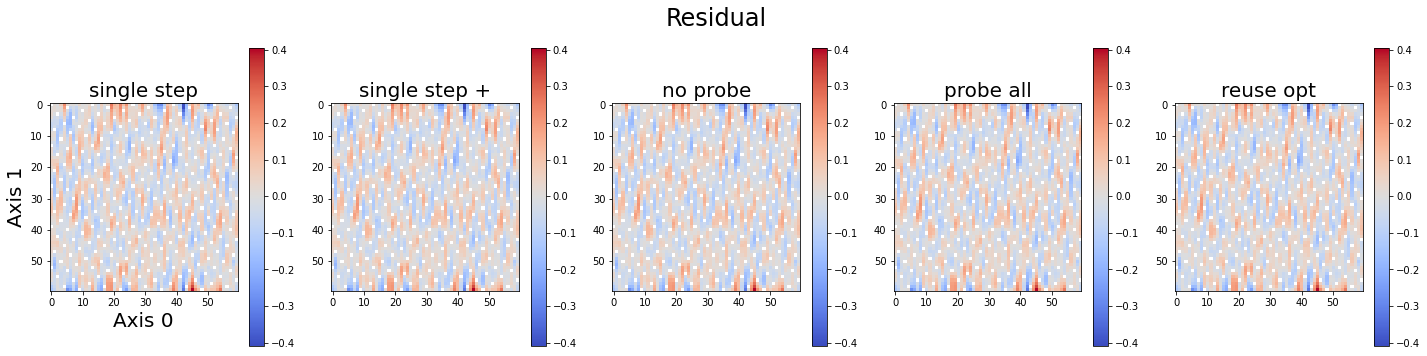

In [16]:
max_len = max(len(header) for header in train_table[0])
sep = "-" * max_len
for row in train_table:
    print("|".join(header.ljust(max_len) for header in row))
    if row == train_table[0]:
        print("|".join(sep for _ in row))
print("\n")
max_len = max(len(header) for header in inference_table[0])
sep = "-" * max_len
for row in inference_table:
    print("|".join(header.ljust(max_len) for header in row))
    if row == inference_table[0]:
        print("|".join(sep for _ in row))

test_im = np.zeros(sampler.data_count)
test_im[sampler._test_mask(), None] = test_responses
pred_im = np.zeros(sampler.data_count)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for index, results in enumerate(inference_data):
    predictions = results[0]
    pred_im[sampler._test_mask(), None] = predictions
    resl_im = test_im - pred_im
    resl_im[sampler._train_mask()] = -np.inf
    im = axes[index].imshow(sampler._make_im(resl_im), cmap="coolwarm")
    cb = fig.colorbar(im, ax=axes[index], orientation='vertical')
    axes[index].set_title(train_table[index + 1][0], fontsize=20)
fig.suptitle("Residual", fontsize=24)
axes[0].set_xlabel("Axis 0", fontsize=20)
axes[0].set_ylabel("Axis 1", fontsize=20)
plt.tight_layout()
plt.show()
